Importing packages

In [75]:
from keras.models import Sequential,Model
from keras.layers import Dense, Activation,Flatten
from keras.utils import np_utils
from keras.layers import Conv2D, MaxPooling2D, Dropout, BatchNormalization, Input, UpSampling2D
import matplotlib.cm as cm #Makes imageplotlib show the images inline #in Jupyter notebooks: 
from keras.optimizers import SGD,Adam
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import matplotlib.patches as patches




### Using the generate functions to create images

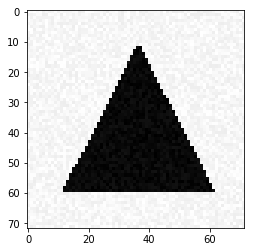

In [76]:


# On some implementations of matplotlib, you may need to change this value
IMAGE_SIZE = 72

def generate_a_drawing(figsize, U, V, noise=0.0):
    fig = plt.figure(figsize=(figsize,figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
    imdata = imdata + noise * np.random.random(imdata.size)
    plt.close(fig)
    return imdata

def generate_a_rectangle(noise=0.0, free_location=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return generate_a_drawing(figsize, U, V, noise)


def generate_a_disk(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return generate_a_drawing(figsize, U, V, noise)

def generate_a_triangle(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    imdata = generate_a_drawing(figsize, U, V, noise)
    return [imdata, [U[0], V[0], U[1], V[1], U[2], V[2]]]


im = generate_a_rectangle(10, True)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

im = generate_a_disk(10)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

[im, v] = generate_a_triangle(20, False)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')


def generate_dataset_classification(nb_samples, noise=0.0, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros(nb_samples)
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        category = np.random.randint(3)
        if category == 0:
            X[i] = generate_a_rectangle(noise, free_location)
        elif category == 1: 
            X[i] = generate_a_disk(noise, free_location)
        else:
            [X[i], V] = generate_a_triangle(noise, free_location)
        Y[i] = category
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

def generate_test_set_classification():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_classification(300, 20, True)
    Y_test = np_utils.to_categorical(Y_test, 3) 
    return [X_test, Y_test]

def generate_dataset_regression(nb_samples, noise=0.0):
    # Getting im_size:
    im_size = generate_a_triangle()[0].shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples, 6])
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        [X[i], Y[i]] = generate_a_triangle(noise, True)
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]



def visualize_prediction(x, y):
    fig, ax = plt.subplots(figsize=(5, 5))
    I = x.reshape((IMAGE_SIZE,IMAGE_SIZE))
    ax.imshow(I, extent=[-0.15,1.15,-0.15,1.15],cmap='gray')
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])

    xy = y.reshape(3,2)
    tri = patches.Polygon(xy, closed=True, fill = False, edgecolor = 'r', linewidth = 5, alpha = 0.5)
    ax.add_patch(tri)

    plt.show()

def generate_test_set_regression():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_regression(300, 20)
    return [X_test, Y_test]



### Question 3 Simple Classification

In [77]:
[X_train, Y_train] = generate_dataset_classification(300, 20)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


In [78]:
X_train.shape

(300, 5184)

In [79]:
Y_train.shape

(300,)

In [80]:
#Changing the Y variable to one hot encoded values
Y_train = np_utils.to_categorical(Y_train) 

In [81]:
Y_train.shape

(300, 3)

In [82]:
Y_train[0:2]

array([[0., 1., 0.],
       [1., 0., 0.]], dtype=float32)

In [83]:
#get number of columns in training data
n_cols = X_train.shape[1]

#### Attempting SGD

In [84]:
#create model
model= Sequential()
#add layers to model 
model.add(Dense(100, activation='relu', input_shape=(n_cols,)))
model.add(Dense(3, activation='softmax'))
#compile model with stochastic gradient optimizer
model.compile(optimizer=SGD(lr=0.001,decay=1e-6, momentum=0.9, nesterov=True), loss='mean_squared_error' )
model.fit(X_train, Y_train, epochs=30, batch_size=64)

Epoch 1/30
300/300 [==============================] - 1s 2ms/step - loss: 0.2402
Epoch 2/30
300/300 [==============================] - 0s 280us/step - loss: 0.2170
Epoch 3/30
300/300 [==============================] - 0s 293us/step - loss: 0.1931
Epoch 4/30
300/300 [==============================] - 0s 293us/step - loss: 0.1774
Epoch 5/30
300/300 [==============================] - 0s 286us/step - loss: 0.1655
Epoch 6/30
300/300 [==============================] - 0s 323us/step - loss: 0.1528
Epoch 7/30
300/300 [==============================] - 0s 293us/step - loss: 0.1402
Epoch 8/30
300/300 [==============================] - 0s 303us/step - loss: 0.1321
Epoch 9/30
300/300 [==============================] - 0s 306us/step - loss: 0.1247
Epoch 10/30
300/300 [==============================] - 0s 276us/step - loss: 0.1181
Epoch 11/30
300/300 [==============================] - 0s 273us/step - loss: 0.1118
Epoch 12/30
300/300 [==============================] - 0s 290us/step - loss: 0.1055
Epo

Attempted epochs from 15-300. The optimizer doesn't converge and loss keeps decreasing. On trying higher learning rates, the optimizer gets stuck at cartain value. Also, without nesterov momentum it gives a much higher loss 

#### Adam optimizer

In [85]:
model1 = Sequential() 
model1.add(Dense(100, activation='relu', input_shape=(n_cols,)))
model1.add(Dense(3, activation='softmax'))
#compile model with adam optimizer
model1.compile(optimizer=Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False), loss='mean_squared_error' )
model1.fit(X_train, Y_train, epochs=50, batch_size=64)

Epoch 1/50
300/300 [==============================] - 1s 2ms/step - loss: 0.2320
Epoch 2/50
300/300 [==============================] - 0s 380us/step - loss: 0.1819
Epoch 3/50
300/300 [==============================] - 0s 356us/step - loss: 0.1388
Epoch 4/50
300/300 [==============================] - 0s 370us/step - loss: 0.1096
Epoch 5/50
300/300 [==============================] - 0s 363us/step - loss: 0.0992
Epoch 6/50
300/300 [==============================] - 0s 336us/step - loss: 0.0950
Epoch 7/50
300/300 [==============================] - 0s 370us/step - loss: 0.0770
Epoch 8/50
300/300 [==============================] - 0s 343us/step - loss: 0.0671
Epoch 9/50
300/300 [==============================] - 0s 356us/step - loss: 0.0609
Epoch 10/50
300/300 [==============================] - 0s 353us/step - loss: 0.0563
Epoch 11/50
300/300 [==============================] - 0s 336us/step - loss: 0.0543
Epoch 12/50
300/300 [==============================] - 0s 346us/step - loss: 0.0502
Epo

With a learning rate >0.001 Adam loss does not move beyond 0.48. 

In [86]:
X_test = generate_a_rectangle()
X_test = X_test.reshape(1, X_test.shape[0])
model1.predict(X_test)
#np.argmax(model.predict(X_test),axis=1)

array([[1., 0., 0.]], dtype=float32)

In [87]:
X_test = generate_a_disk()
X_test = X_test.reshape(1, X_test.shape[0])
model1.predict(X_test)
#np.argmax(model.predict(X_test),axis=1)

array([[0., 1., 0.]], dtype=float32)

In [88]:
X_test = generate_a_triangle()[0]
X_test = X_test.reshape(1, X_test.shape[0])
model1.predict(X_test)
#np.argmax(model.predict(X_test),axis=1)

array([[0., 0., 1.]], dtype=float32)

In [89]:
X_test = generate_a_rectangle()
X_test = X_test.reshape(1, X_test.shape[0])
model.predict(X_test)
#np.argmax(model.predict(X_test),axis=1)

array([[1., 0., 0.]], dtype=float32)

In [90]:
X_test = generate_a_disk()
X_test = X_test.reshape(1, X_test.shape[0])
model.predict(X_test)
#np.argmax(model.predict(X_test),axis=1)

array([[0., 1., 0.]], dtype=float32)

In [91]:
X_test = generate_a_triangle()[0]
X_test = X_test.reshape(1, X_test.shape[0])
model.predict(X_test)
#np.argmax(model.predict(X_test),axis=1)

array([[0., 0., 1.]], dtype=float32)

Both optimizers have given correct predictions. However they dont appear to converge fast. Also, adam requires a lower learning rate for this result

### Question 4 - Visualization of weights

In [103]:
w1 = model1.get_weights()
for w in w1:
    print(w.shape)

(5184, 100)
(100,)
(100, 3)
(3,)


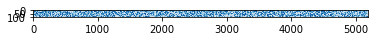

In [105]:
I = w1[0].reshape(100,5184)
plt.imshow(I, cmap = cm.Blues)


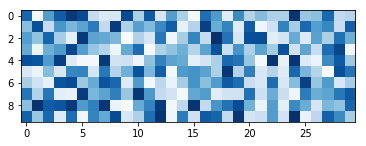

In [107]:
I = w1[2].reshape(10,30)
plt.imshow(I, cmap = cm.Blues)


### Question 5 - More Difficult Classification

In [125]:
[X_train, Y_train] = generate_dataset_classification(1000, 20, True)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990


In [126]:
Y_train= np_utils.to_categorical(Y_train, 3)

Using the previous network on the noisy data to see the loss. 

In [128]:
model2 = Sequential() 
model2.add(Dense(100, activation='relu', input_shape=(n_cols,)))
model2.add(Dense(3, activation='softmax'))
#compile model with adam optimizer
model2.compile(optimizer=Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False), loss='categorical_crossentropy', metrics=['accuracy'] )
model2.fit(X_train, Y_train, epochs=10, batch_size=64)

Epoch 1/10
1000/1000 [==============================] - 2s 2ms/step - loss: 1.2355 - acc: 0.3780
Epoch 2/10
1000/1000 [==============================] - 0s 385us/step - loss: 1.0707 - acc: 0.4200
Epoch 3/10
1000/1000 [==============================] - 0s 382us/step - loss: 1.0110 - acc: 0.4530
Epoch 4/10
1000/1000 [==============================] - 0s 405us/step - loss: 1.0111 - acc: 0.4700
Epoch 5/10
1000/1000 [==============================] - 0s 390us/step - loss: 0.9455 - acc: 0.4970
Epoch 6/10
1000/1000 [==============================] - 0s 375us/step - loss: 0.9000 - acc: 0.5270
Epoch 7/10
1000/1000 [==============================] - 0s 401us/step - loss: 0.8867 - acc: 0.5300
Epoch 8/10
1000/1000 [==============================] - 0s 393us/step - loss: 0.8903 - acc: 0.5550
Epoch 9/10
1000/1000 [==============================] - 0s 395us/step - loss: 0.8697 - acc: 0.5530
Epoch 10/10
1000/1000 [==============================] - 0s 389us/step - loss: 0.8500 - acc: 0.5700


With the previous network is relatively high in 10 epochs(using categorical cross entropy). Now let's try on a convolutional network.

In [129]:
X_train = X_train.reshape(X_train.shape[0], 72, 72,1)

In [130]:
X_train.shape

(1000, 72, 72, 1)

In [135]:

#add layers to model
model3 = Sequential()
#Using a single convolutional layer with 16 5x5 filters
model3.add(Conv2D(16,(5,5), activation='relu', input_shape=(72,72,1)))
model3.add(MaxPooling2D(pool_size=(2,2)))
model3.add(Flatten())
model3.add(Dense(3, activation='softmax'))

In [136]:
model3.output_shape

(None, 3)

In [137]:
#compile model with adam
#sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
adam=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model3.compile(optimizer=adam, loss='categorical_crossentropy',metrics=['accuracy'])

In [138]:
model3.fit(X_train, Y_train, epochs=20, batch_size=32)

Epoch 1/20
1000/1000 [==============================] - 6s 6ms/step - loss: 1.0791 - acc: 0.4920
Epoch 2/20
1000/1000 [==============================] - 4s 4ms/step - loss: 0.7521 - acc: 0.6970
Epoch 3/20
1000/1000 [==============================] - 4s 4ms/step - loss: 0.6772 - acc: 0.7300
Epoch 4/20
1000/1000 [==============================] - 4s 4ms/step - loss: 0.6032 - acc: 0.7640
Epoch 5/20
1000/1000 [==============================] - 4s 4ms/step - loss: 0.5291 - acc: 0.8180
Epoch 6/20
1000/1000 [==============================] - 4s 4ms/step - loss: 0.4960 - acc: 0.8370
Epoch 7/20
1000/1000 [==============================] - 5s 5ms/step - loss: 0.4922 - acc: 0.8120
Epoch 8/20
1000/1000 [==============================] - 4s 4ms/step - loss: 0.4317 - acc: 0.8630
Epoch 9/20
1000/1000 [==============================] - 4s 4ms/step - loss: 0.4155 - acc: 0.8550
Epoch 10/20
1000/1000 [==============================] - 5s 5ms/step - loss: 0.3695 - acc: 0.8870
Epoch 11/20
1000/1000 [======

Using adam gives a better training accuracy and loss than sgd in this case. Also it is clear that we are able to achieve much better results than the linear classifier.

In [139]:
[X_test, Y_test] = generate_test_set_classification()

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


In [140]:
X_test.shape

(300, 5184)

In [141]:
X_test=X_test.reshape(300,72,72,1)

In [142]:
score,acc=model3.evaluate(X_test, Y_test)
print('Test score:', score)
print('Test accuracy:', acc)

300/300 [==============================] - 1s 5ms/step
Test score: 0.4095084985097249
Test accuracy: 0.8533333325386048


Tried with training set of 300 rows and 1000 rows. Test accuracy improved from 64 to 85

Adding additional convolutional layer to see if there's an improvement

In [145]:

model4 = Sequential()
model4.add(Conv2D(16,(5,5), activation='relu', input_shape=(72,72,1)))
model4.add(MaxPooling2D(pool_size=(2,2)))
model4.add(Conv2D(16,(3,3), activation='relu'))
model4.add(Flatten())
model4.add(Dense(3, activation='softmax'))
model4.compile(optimizer=adam, loss='categorical_crossentropy',metrics=['accuracy'])
model4.fit(X_train, Y_train, epochs=15, batch_size=32)

Epoch 1/15
1000/1000 [==============================] - 9s 9ms/step - loss: 1.2938 - acc: 0.4970
Epoch 2/15
1000/1000 [==============================] - 8s 8ms/step - loss: 0.7203 - acc: 0.7000
Epoch 3/15
1000/1000 [==============================] - 8s 8ms/step - loss: 0.4687 - acc: 0.8510
Epoch 4/15
1000/1000 [==============================] - 8s 8ms/step - loss: 0.2357 - acc: 0.9290
Epoch 5/15
1000/1000 [==============================] - 9s 9ms/step - loss: 0.2945 - acc: 0.9170
Epoch 6/15
1000/1000 [==============================] - 10s 10ms/step - loss: 0.3081 - acc: 0.9130
Epoch 7/15
1000/1000 [==============================] - 9s 9ms/step - loss: 0.1805 - acc: 0.9400
Epoch 8/15
1000/1000 [==============================] - 9s 9ms/step - loss: 0.1729 - acc: 0.9590
Epoch 9/15
1000/1000 [==============================] - 8s 8ms/step - loss: 0.1626 - acc: 0.9660
Epoch 10/15
1000/1000 [==============================] - 9s 9ms/step - loss: 0.0972 - acc: 0.9730
Epoch 11/15
1000/1000 [====

Achieved much lower training loss. Possibly overfitting 

In [146]:
score,acc=model4.evaluate(X_test, Y_test)
print('Test score:', score)
print('Test accuracy:', acc)

300/300 [==============================] - 2s 5ms/step
Test score: 0.2185652236143748
Test accuracy: 0.946666665871938


Adding the convolutional layer has improved test accuracy to 94

Including dropout of 20% after each layer to minimize overfitting 

In [148]:

model5 = Sequential()
model5.add(Conv2D(16,(5,5), activation='relu', input_shape=(72,72,1)))
model5.add(Dropout(0.2))
model5.add(MaxPooling2D(pool_size=(2,2)))
model5.add(Conv2D(16,(3,3), activation='relu'))
model5.add(Dropout(0.2))
model5.add(Flatten())
model5.add(Dense(3, activation='softmax'))
model5.compile(optimizer=adam, loss='categorical_crossentropy',metrics=['accuracy'])
model5.fit(X_train, Y_train, epochs=15, batch_size=32)

Epoch 1/15
1000/1000 [==============================] - 10s 10ms/step - loss: 0.9978 - acc: 0.5150
Epoch 2/15
1000/1000 [==============================] - 10s 10ms/step - loss: 0.7727 - acc: 0.6640
Epoch 3/15
1000/1000 [==============================] - 10s 10ms/step - loss: 0.6127 - acc: 0.7670
Epoch 4/15
1000/1000 [==============================] - 9s 9ms/step - loss: 0.4748 - acc: 0.8200
Epoch 5/15
1000/1000 [==============================] - 10s 10ms/step - loss: 0.3726 - acc: 0.8690
Epoch 6/15
1000/1000 [==============================] - 11s 11ms/step - loss: 0.3069 - acc: 0.8940
Epoch 7/15
1000/1000 [==============================] - 13s 13ms/step - loss: 0.2669 - acc: 0.9130
Epoch 8/15
1000/1000 [==============================] - 13s 13ms/step - loss: 0.1890 - acc: 0.9520
Epoch 9/15
1000/1000 [==============================] - 12s 12ms/step - loss: 0.1631 - acc: 0.9490
Epoch 10/15
1000/1000 [==============================] - 14s 14ms/step - loss: 0.1269 - acc: 0.9720
Epoch 11/15

In [149]:
score,acc=model5.evaluate(X_test, Y_test)
print('Test score:', score)
print('Test accuracy:', acc)

300/300 [==============================] - 3s 10ms/step
Test score: 0.4198941707611084
Test accuracy: 0.8466666666666667


Including dropout decreased test accuracy. 

### Question 6 - Regression

In [179]:
[X_train, Y_train] = generate_dataset_regression(3000, 20)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2080
2090
2100
2110
2120
2130
2140
2150
2160
2170
2180
2

In [180]:
X_train.shape


(3000, 5184)

Normalizing the Y train data by sorting the vertices along the X axis in order to better train the model

In [181]:
x_coords=Y_train[:,[0,2,4]]
y_coords=Y_train[:,[1,3,5]]
for i in range(len(x_coords)):
    x_coords[i,], y_coords[i,] = zip(*sorted(zip(x_coords[i,], y_coords[i,])))

In [182]:
Y_train.shape[1]

6

In [183]:
Y_train[0:5,]

array([[0.92704858, 0.44151234, 0.73080738, 0.20193444, 0.11011213,
        0.54167612],
       [0.96324639, 0.27569097, 0.90210763, 0.30098948, 0.13635942,
        0.2313118 ],
       [0.83866913, 0.68647619, 0.99724311, 0.33991525, 0.6849049 ,
        0.23023945],
       [0.43292445, 0.93348464, 0.00325116, 0.6629878 , 0.87564712,
        0.05350732],
       [0.0519455 , 0.40524589, 0.16920486, 0.96094859, 0.98670135,
        0.54276892]])

In [184]:
x_coords[0:5,]

array([[0.11011213, 0.73080738, 0.92704858],
       [0.13635942, 0.90210763, 0.96324639],
       [0.6849049 , 0.83866913, 0.99724311],
       [0.00325116, 0.43292445, 0.87564712],
       [0.0519455 , 0.16920486, 0.98670135]])

In [185]:
y_coords[0:5,]

array([[0.54167612, 0.20193444, 0.44151234],
       [0.2313118 , 0.30098948, 0.27569097],
       [0.23023945, 0.68647619, 0.33991525],
       [0.6629878 , 0.93348464, 0.05350732],
       [0.40524589, 0.96094859, 0.54276892]])

In [186]:
for i in range(len(x_coords)):
    for j in range(Y_train.shape[1]):
        if j%2==0:
                a=int(j/2)
                Y_train[i,j]=x_coords[i,a]
        else:
                b=int((j-1)/2)
                Y_train[i,j]=y_coords[i,b]    

In [187]:
X_train = X_train.reshape(X_train.shape[0], 72, 72,1)

In [208]:

model6 = Sequential()
model6.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(72,72,1)))
model6.add(MaxPooling2D((2, 2)))
model6.add(Dropout(0.25))

model6.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model6.add(MaxPooling2D(pool_size=(2, 2)))
model6.add(Dropout(0.25))

model6.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model6.add(Dropout(0.4))

model6.add(Flatten())

model6.add(Dense(128, activation='relu'))
model6.add(Dense(6))
model6.compile(loss='mean_squared_error',optimizer='adam',metrics=['accuracy'])

In [209]:

model6.fit(X_train,Y_train,epochs=30,batch_size=128)


Epoch 1/30
3000/3000 [==============================] - 75s 25ms/step - loss: 1.1444 - acc: 0.2673
Epoch 2/30
3000/3000 [==============================] - 76s 25ms/step - loss: 0.0731 - acc: 0.4943
Epoch 3/30
3000/3000 [==============================] - 85s 28ms/step - loss: 0.0635 - acc: 0.5250
Epoch 4/30
3000/3000 [==============================] - 98s 33ms/step - loss: 0.0566 - acc: 0.5247
Epoch 5/30
3000/3000 [==============================] - 100s 33ms/step - loss: 0.0397 - acc: 0.5567
Epoch 6/30
3000/3000 [==============================] - 106s 35ms/step - loss: 0.0345 - acc: 0.5840
Epoch 7/30
3000/3000 [==============================] - 103s 34ms/step - loss: 0.0322 - acc: 0.5920
Epoch 8/30
3000/3000 [==============================] - 117s 39ms/step - loss: 0.0299 - acc: 0.6060
Epoch 9/30
3000/3000 [==============================] - 122s 41ms/step - loss: 0.0270 - acc: 0.6403
Epoch 10/30
3000/3000 [==============================] - 114s 38ms/step - loss: 0.0253 - acc: 0.6543
Epo

In [216]:
[X_test, Y_test] = generate_test_set_regression()


Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


In [217]:
xt_coords=Y_test[:,[0,2,4]]
yt_coords=Y_test[:,[1,3,5]]
for i in range(len(xt_coords)):
    xt_coords[i,], yt_coords[i,] = zip(*sorted(zip(xt_coords[i,], yt_coords[i,])))

In [218]:
for i in range(len(xt_coords)):
    for j in range(Y_test.shape[1]):
        if j%2==0:
                a=int(j/2)
                Y_test[i,j]=xt_coords[i,a]
        else:
                b=int((j-1)/2)
                Y_test[i,j]=yt_coords[i,b] 

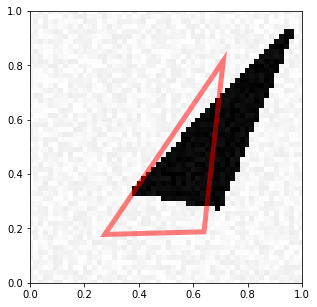

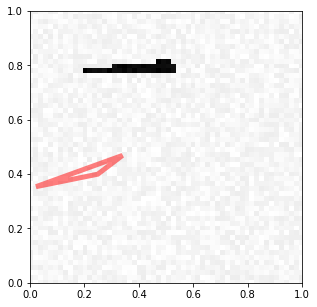

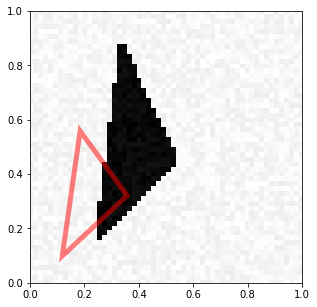

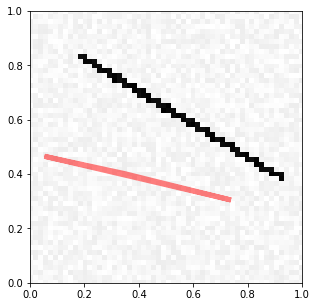

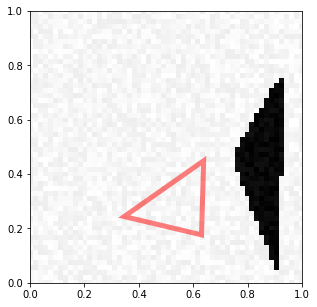

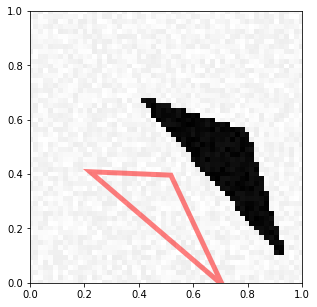

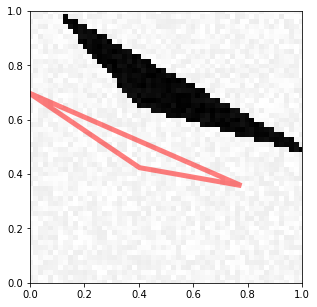

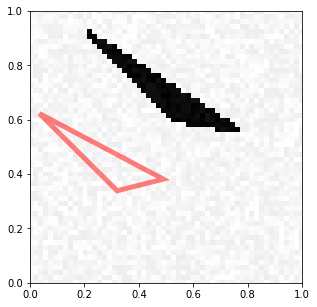

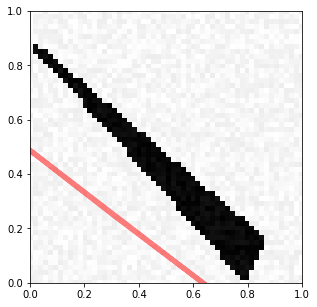

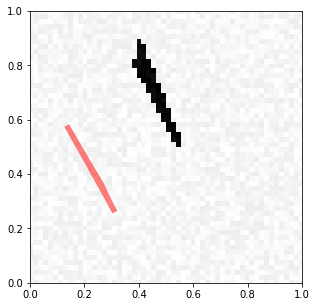

In [222]:
Y_predict=model6.predict(X_test.reshape(300,72,72,1)) 

#Visualizing the Regression
for x in range(10):
    visualize_prediction(X_test[x],Y_predict[x])

In [221]:
score,acc=model6.evaluate(X_test.reshape(300,72,72,1), Y_test)
print('Test score:', score)
print('Test accuracy:', acc)

300/300 [==============================] - 2s 6ms/step
Test score: 0.04527309849858284
Test accuracy: 0.78


Able to achieve decent loss and accuracy on the training set. However the prediction could be better. The vertices are predicted quite accurately with respect to each other. We can see that most predictions are similar to the test triangle. However there is a drift. Also since it has more layers takes substantial time on local. 

Trying a simpler model with a dataset of 5,000 images 

In [226]:
[X_train, Y_train] = generate_dataset_regression(5000, 20)
x_coords=Y_train[:,[0,2,4]]
y_coords=Y_train[:,[1,3,5]]
for i in range(len(x_coords)):
    x_coords[i,], y_coords[i,] = zip(*sorted(zip(x_coords[i,], y_coords[i,])))
X_train = X_train.reshape(X_train.shape[0], 72, 72,1)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2080
2090
2100
2110
2120
2130
2140
2150
2160
2170
2180
2

Epoch 1/15
5000/5000 [==============================] - 39s 8ms/step - loss: 0.6461 - acc: 0.1926
Epoch 2/15
5000/5000 [==============================] - 43s 9ms/step - loss: 0.0659 - acc: 0.2676
Epoch 3/15
5000/5000 [==============================] - 42s 8ms/step - loss: 0.0591 - acc: 0.2918
Epoch 4/15
5000/5000 [==============================] - 48s 10ms/step - loss: 0.0568 - acc: 0.3128
Epoch 5/15
5000/5000 [==============================] - 39s 8ms/step - loss: 0.0534 - acc: 0.3412
Epoch 6/15
5000/5000 [==============================] - 44s 9ms/step - loss: 0.0518 - acc: 0.3492
Epoch 7/15
5000/5000 [==============================] - 47s 9ms/step - loss: 0.0494 - acc: 0.3700
Epoch 8/15
5000/5000 [==============================] - 46s 9ms/step - loss: 0.0467 - acc: 0.3990
Epoch 9/15
5000/5000 [==============================] - 45s 9ms/step - loss: 0.0443 - acc: 0.4196
Epoch 10/15
5000/5000 [==============================] - 43s 9ms/step - loss: 0.0438 - acc: 0.4202
Epoch 11/15
5000/5

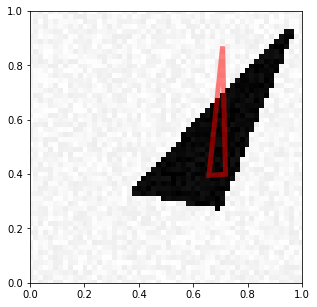

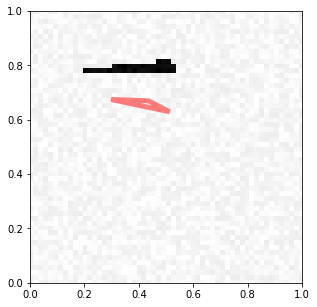

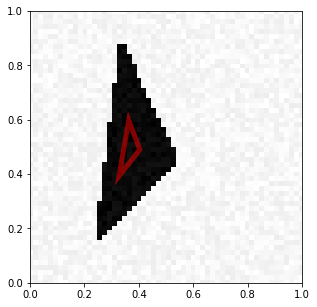

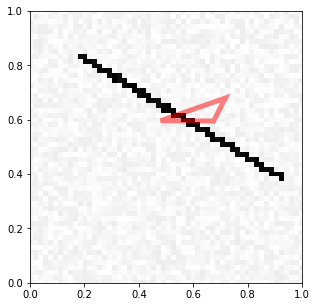

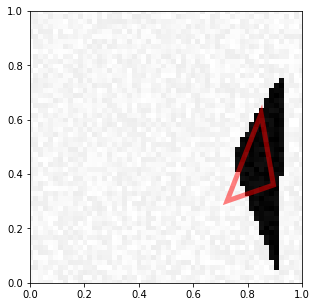

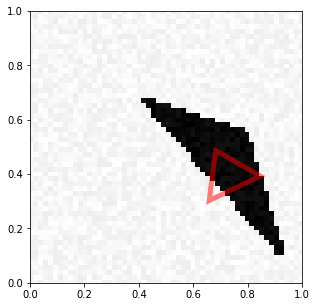

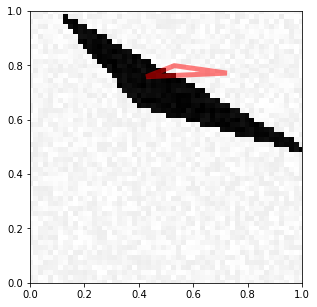

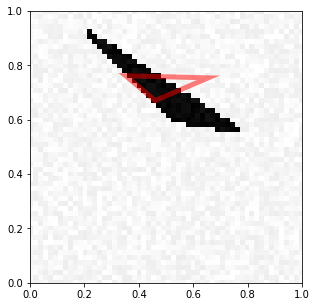

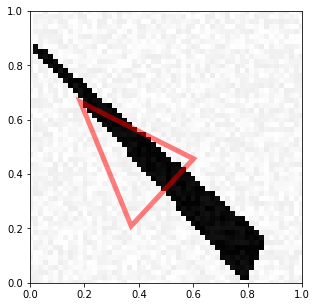

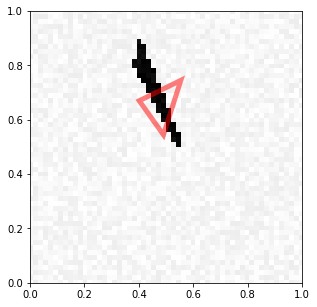

In [228]:

model7 = Sequential()
model7.add(Conv2D(16,(5,5),activation = 'relu' , input_shape=(72,72,1)))
model7.add(MaxPooling2D(pool_size=(2,2)))
model7.add(Activation("relu"))
model7.add(Flatten())
model7.add(Dense(6))
model7.compile(loss='mean_squared_error',optimizer='adam',metrics=['accuracy'])
model7.fit(X_train,Y_train,epochs=15,batch_size=64)
Y_predict=model7.predict(X_test.reshape(300,72,72,1)) 

#Visualizing the Regression
for x in range(10):
    visualize_prediction(X_test[x],Y_predict[x])

The previous model with 4 layers performs much better. This appears to give very bad predictions

### Question 7 - Denoising 

Modifying the generate image functions by passing a non zero value for noise which is then randomized. These functions return 2 images - a noisy and clean image. This will then be run on an hourglass model.

In [57]:

IMAGE_SIZE = 72

def generate_a_drawing_pair(figsize, U, V, noise=10.0):
    fig = plt.figure(figsize=(figsize,figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
    imdata_noisy = imdata + noise * np.random.random(imdata.size)
    plt.close(fig)
    return [imdata,imdata_noisy]

def generate_a_rectangle_pair(noise=10.0, free_location=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return generate_a_drawing_pair(figsize, U, V, noise)


def generate_a_disk_pair(noise=10.0, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return generate_a_drawing_pair(figsize, U, V, noise)

def generate_a_triangle_pair(noise=10.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    imdata,imdata_noisy = generate_a_drawing_pair(figsize, U, V, noise)
    return [imdata,imdata_noisy, [U[0], V[0], U[1], V[1], U[2], V[2]]]


def generate_dataset_denoising(nb_samples, noise=10.0, free_location=False):
    # Getting im_size:
    x, x_n = generate_a_rectangle_pair()
    im_size = x.shape[0]
    X = np.zeros([nb_samples,im_size])
    X_noise= np.zeros([nb_samples,im_size])
    #Y = np.zeros(nb_samples)
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        category = np.random.randint(3)
        if category == 0:
            [X[i],X_noise[i]] = generate_a_rectangle_pair(noise, free_location)
        elif category == 1: 
            [X[i],X_noise[i]] = generate_a_disk_pair(noise, free_location)
        else:
            [X[i],X_noise[i], V] = generate_a_triangle_pair(noise, free_location)
    return [X, X_noise]


def generate_test_set_denoising():
    np.random.seed(42)
    [X_test, X_noise_test] = generate_dataset_denoising(300)
    return [X_test, X_noise_test]

In [58]:
im1,im2 = generate_a_rectangle_pair()

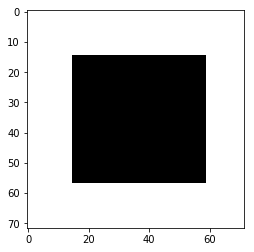

In [59]:
plt.imshow(im1.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

In [60]:
im2

array([256.02891918, 262.30823202, 264.93768707, ..., 258.53598692,
       258.62283206, 264.35863546])

In [61]:
[X_train, X_noise_train] = generate_dataset_denoising(300)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


Scaling the data- attempted the model without scaling and achieved extrmely poor results.

In [62]:
X_train/=255
X_noise_train/=255

In [63]:
X_train_re= X_train.reshape(X_train.shape[0], 72, 72,1)
X_noise_train_re = X_noise_train.reshape(X_noise_train.shape[0], 72, 72,1)

In [64]:
input_img = Input(shape=(72, 72, 1))


In [65]:

# "encoded" is the encoded representation of the input
encoded = Conv2D(128, (3,3), activation='relu', padding='same')(input_img)
encoded = MaxPooling2D((2, 2), padding='same')(encoded)
encoded = Conv2D(64, (3,3), activation='relu', padding='same')(encoded)
encoded = MaxPooling2D((2, 2), padding='same')(encoded)
encoded = Conv2D(32, (3,3), activation='relu', padding='same')(encoded)
encoded = MaxPooling2D((2, 2), padding='same')(encoded)
encoded = Conv2D(16, (3,3), activation='relu', padding='same')(encoded)
encoded = MaxPooling2D((2, 2), padding='same')(encoded)

# "decoded" is the lossy reconstruction of the input
decoded = Conv2D(16, (3,3), activation='relu', padding='same')(encoded)
decoded = UpSampling2D((2, 2))(decoded)
decoded = Conv2D(32, (3,3), activation='relu', padding='same')(decoded)
decoded = UpSampling2D((2, 2))(decoded)
decoded = Conv2D(64, (3,3), activation='relu')(decoded)
decoded = UpSampling2D((2, 2))(decoded)
decoded = Conv2D(128, (3,3), activation='relu', padding='same')(decoded)
decoded = UpSampling2D((2, 2))(decoded)
decoded = Conv2D(1, (3,3), padding='same')(decoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)

In [66]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 72, 72, 1)         0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 72, 72, 128)       1280      
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 36, 36, 128)       0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 36, 36, 64)        73792     
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 18, 18, 64)        0         
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 18, 18, 32)        18464     
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 9, 9, 32)          0         
__________

In [67]:
encoder = Model(input_img, encoded)

In [68]:
autoencoder.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

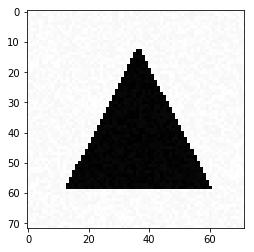

In [69]:
plt.imshow(X_noise_train_re[0].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

In [70]:
train_history = autoencoder.fit(X_noise_train_re, X_train_re, epochs=13, batch_size=32)

Epoch 1/13
300/300 [==============================] - 73s 245ms/step - loss: 0.3039 - acc: 0.6039
Epoch 2/13
300/300 [==============================] - 93s 311ms/step - loss: 0.1001 - acc: 0.8686
Epoch 3/13
300/300 [==============================] - 108s 361ms/step - loss: 0.0673 - acc: 0.9362
Epoch 4/13
300/300 [==============================] - 134s 447ms/step - loss: 0.0472 - acc: 0.9557
Epoch 5/13
300/300 [==============================] - 130s 432ms/step - loss: 0.0363 - acc: 0.9650
Epoch 6/13
300/300 [==============================] - 157s 524ms/step - loss: 0.0317 - acc: 0.9693
Epoch 7/13
300/300 [==============================] - 142s 473ms/step - loss: 0.0274 - acc: 0.9746
Epoch 8/13
300/300 [==============================] - 146s 486ms/step - loss: 0.0262 - acc: 0.9759
Epoch 9/13
300/300 [==============================] - 114s 379ms/step - loss: 0.0234 - acc: 0.9790
Epoch 10/13
300/300 [==============================] - 29s 97ms/step - loss: 0.0226 - acc: 0.9792
Epoch 11/13
3

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


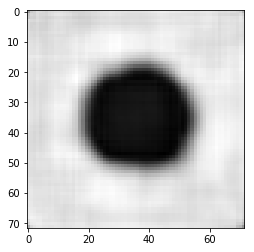

In [71]:
[X_test, X_noise_test] = generate_test_set_denoising()
X_noise_test/=255
X_test_re= X_test.reshape(X_test.shape[0], 72, 72,1)
X_noise_test_re = X_noise_test.reshape(X_noise_test.shape[0], 72, 72,1)
pred = autoencoder.predict(X_noise_test_re)
pred*=255
plt.imshow(pred[0].reshape(72, 72), cmap='gray')


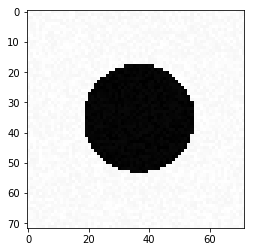

In [72]:
plt.imshow(X_noise_test_re[0].reshape(72, 72), cmap='gray')